In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
from LRBv21 import LRBv21
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



In [2]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()

store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}

In [3]:
sepadd = 2
eqb = dict()

for design in designs:  
    eqb[design] = dict()
    for side in ["iu", "ou"]:
        eqb[design][side] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 5000)

eqb["SPR38_hiq"] = copy.deepcopy(eqb["SPR38"])

print("Complete")

Complete


# Front profile comparisons

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


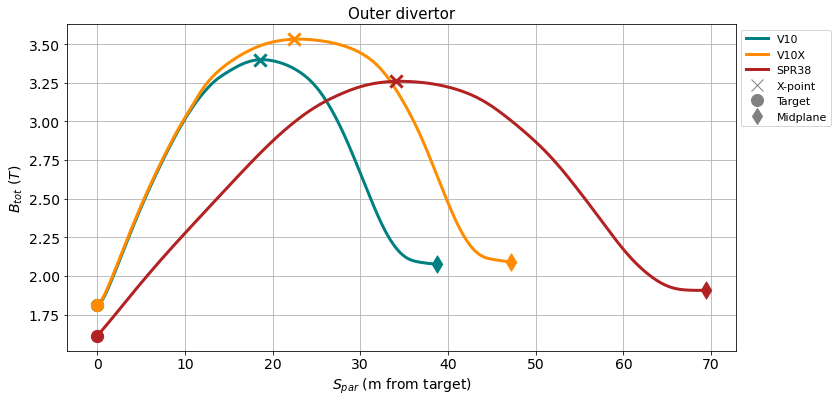

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Outer divertor", fontsize = 15)
side = "ou"

colors = mike_cmap(3)

for i, design in enumerate(designs):
    
    d = eqb[design][side]
    
    ax.plot(d["S"], d["Btot"], linewidth = 3, label = design, zorder = 5, color = colors[i])    
    # ax.vlines(d["S"][d["Xpoint"]], 1,d["Btot"][d["Xpoint"]], color = colors[i], linestyle = "solid",linewidth =2, alpha = 0.3)
    ax.scatter(d["S"][d["Xpoint"]], d["Btot"][d["Xpoint"]], color = colors[i], marker = "x",  s = 150,zorder = 50)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o",  s = 150,zorder = 300)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d",  s = 150,zorder = 300)



ax.set_xlabel("$S_{par}$ (m from target)"); 
ax.set_ylabel("$B_{tot}\ (T)$")

h,l = ax.get_legend_handles_labels()
extra_handles = [mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 12),
                mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target", markersize = 12),
                mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane", markersize = 12)]

fig.legend(loc="upper right", handles = h+extra_handles, bbox_to_anchor=(1.15,1), bbox_transform=ax.transAxes, fontsize = 11)



# Scale V10 to be like SPR38

In [6]:
side = "ou"
eqb["V10_SPR38"] = dict()
eqb["V10_SPR38_2"] = dict()
eqb["V10_SPR38_3"] = dict()

for side in ["ou", "iu"]:
    A = "V10"
    B = "SPR38"

    Lc = dict()
    BxBt = dict()
    Bx = dict()

    for design in [A, B]:
        d = eqb[design][side]
        Xpoint = d["Xpoint"]
        Lc[design] = d["S"][Xpoint]
        BxBt[design] = d["Btot"][Xpoint] / d["Btot"][0]
        Bx[design] = d["Btot"][Xpoint]

    Lc_scale = Lc[B] / Lc[A]
    BxBt_scale = BxBt[B] / BxBt[A]
    B_scale = Bx[B] / Bx[A]

    d = copy.deepcopy(eqb["V10"][side])
    d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
    d["Btot"] = d["Btot"] * B_scale
    d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
    
    eqb["V10_SPR38"][side] = copy.deepcopy(d)
    eqb["V10_SPR38_2"][side] = copy.deepcopy(d)
    
    new = eqb["V10_SPR38_2"][side]
    old = eqb["SPR38"][side]
    
    S_ratio = (old["S"][-1] - old["S"][old["Xpoint"]]) / (new["S"][-1] - new["S"][new["Xpoint"]])
    
    
    S_offset = old["S"][-1] - new["S"][-1]

    new["S"][new["Xpoint"]+1:] = new["S"][new["Xpoint"]+1:] * S_ratio 
    S_offset = old["S"][-1] - new["S"][-1]
    new["S"][new["Xpoint"]+1:] = new["S"][new["Xpoint"]+1:] + S_offset
    print(S_ratio)

    
#     eqb["V10_SPR38_2"][side]["S"][Xpoint:] = eqb["SPR38"][side]["S"]
#     eqb["V10_SPR38_2"][side]["Spol"][Xpoint:] = eqb["SPR38"][side]["Spol"]
    

    # d_new = copy.deepcopy(eqb["V10"][side])


1.745962211567802
1.5914511878330257


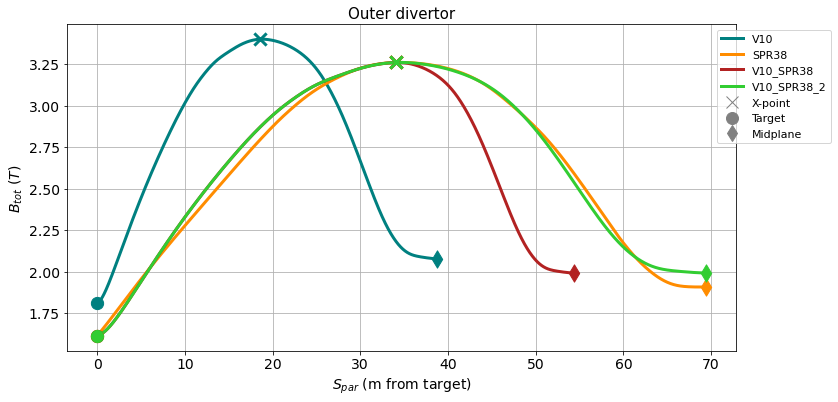

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Outer divertor", fontsize = 15)
side = "ou"

colors = mike_cmap(4)

for i, design in enumerate(["V10", "SPR38", "V10_SPR38", "V10_SPR38_2"]):
# for i, design in enumerate(["SPR38","V10_SPR38_2"]):
    
    d = eqb[design][side]
    
    ax.plot(d["S"], d["Btot"], linewidth = 3, label = design, zorder = 5, color = colors[i])#, marker = "o")    
    # ax.vlines(d["S"][d["Xpoint"]], 1,d["Btot"][d["Xpoint"]], color = colors[i], linestyle = "solid",linewidth =2, alpha = 0.3)
    ax.scatter(d["S"][d["Xpoint"]], d["Btot"][d["Xpoint"]], color = colors[i], marker = "x",  s = 150,zorder = 50)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o",  s = 150,zorder = 300)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d",  s = 150,zorder = 300)

ax.set_xlabel("$S_{par}$ (m from target)"); 
ax.set_ylabel("$B_{tot}\ (T)$")

h,l = ax.get_legend_handles_labels()
extra_handles = [mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 12),
                mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target", markersize = 12),
                mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane", markersize = 12)]

fig.legend(loc="upper right", handles = h+extra_handles, bbox_to_anchor=(1.15,1), bbox_transform=ax.transAxes, fontsize = 11)



## Run

In [11]:
list_cvars = ["density"]
list_designs = ["SPR38", "V10_SPR38", "V10_SPR38_2"]

hiq_multiplier = 220/100

store = dict()

for design in list_designs:
    store[design] = dict()
    print("Design {}...".format(design), end = "")
    
    for cvar in list_cvars:
        store[design][cvar] = dict()
        print(f"Variable {cvar}...", end = "")
    
        for side in ["iu","ou"]:
            print("Side {}...".format(side))

            d = eqb[design][side].copy()
            constants = constants_default.copy()
            radios = radios_default.copy()
            constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint   
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
            SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 7)
            indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange] 
            constants["Lfunc"] = LfuncN
            if design == "SPR38_hiq":
                q_mult = 220/100
            else:
                q_mult = 1
            
            if side == "iu":
                constants["qpllu0"] = 1e8*q_mult
            elif side == "ou":
                constants["qpllu0"] = 1e9*q_mult
            
            store[design][cvar][side] = LRBv21(constants,radios,d["S"],d["Spol"], indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = cvar, qradial_fix2 = True)

syn_spr = copy.deepcopy(store)

Design SPR38...Variable density...Side iu...
qradial: 1.374E+06
Solving...0...209...344...429...475...503...529...Complete in 28.2 seconds
Side ou...
qradial: 3.470E+07
Solving...0...557...948...1302...1542...1661...1706...Complete in 27.6 seconds
Design V10_SPR38...Variable density...Side iu...
qradial: 2.149E+06
Solving...0...219...360...449...498...530...557...Complete in 30.5 seconds
Side ou...
qradial: 6.055E+07
Solving...0...677...1155...1511...1705...1795...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
1835...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:411: RuntimeWarning: divide by zero encountered in double_scalars
  Qrad.append(((cvar**2*Tu**2)/Tf**2)*cz0*Lfunc(Tf))
C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:411: RuntimeWarning: invalid value encountered in double_scalars
  Qrad.append(((cvar**2*Tu**2)/Tf**2)*cz0*Lfunc(Tf))


Complete in 30.6 seconds
Design V10_SPR38_2...Variable density...Side iu...
qradial: 1.351E+06
Solving...0...219...360...449...498...530...557...Complete in 30.9 seconds
Side ou...
qradial: 3.468E+07
Solving...0...677...1155...1511...1705...1795...******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******


C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:371: RuntimeWarning: invalid value encountered in double_scalars
  error0 = (Tu-Tucalc)/Tu


******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
1835...Complete in 132.5 seconds


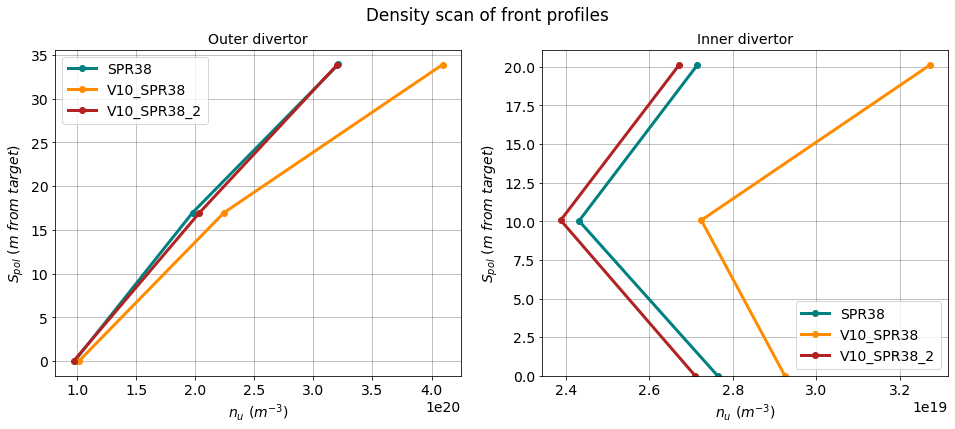

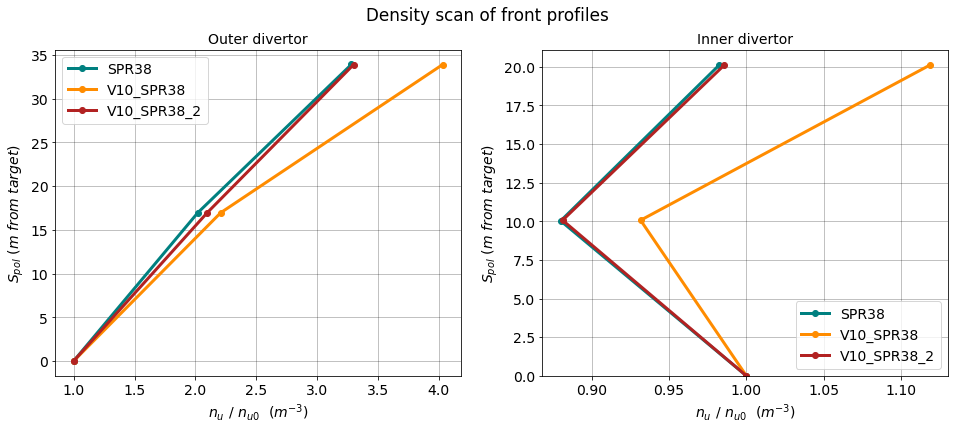

In [212]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}

store = syn_spr
cvar = "density"
colors = mike_cmap(3)
list_designs = ["SPR38", "V10_SPR38", "V10_SPR38_2"]


for basis in ["cvar", "crel"]:
    
    fig, axes = plt.subplots(1,2, figsize = (16,6))
    fig.suptitle("Density scan of front profiles")
    ax = axes[0]
    
    for k, design in enumerate(list_designs):
        for i, side in enumerate(["ou", "iu"]):
            o = store[design][cvar][side].copy()
            
            axes[i].plot(o[basis], o["Splot"],  marker = "o", label = design, markersize = 6, linewidth = 3, color = colors[k])

    ylims = axes[1].get_ylim()
    axes[1].set_ylim(0,ylims[1])

    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel(labels[basis])
        ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
        ax.legend()
        
    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")
    


In [213]:
thresholds = [syn_spr[design][cvar][side]["threshold"] for design in list_designs]
windows = [syn_spr[design][cvar][side]["window_ratio"] for design in list_designs]

print(thresholds)
print(windows)


[2.7636718749999997e+19, 2.9248046874999996e+19, 2.7099609375000003e+19]
[0.982332155477032, 1.1185308848080135, 0.9855855855855854]


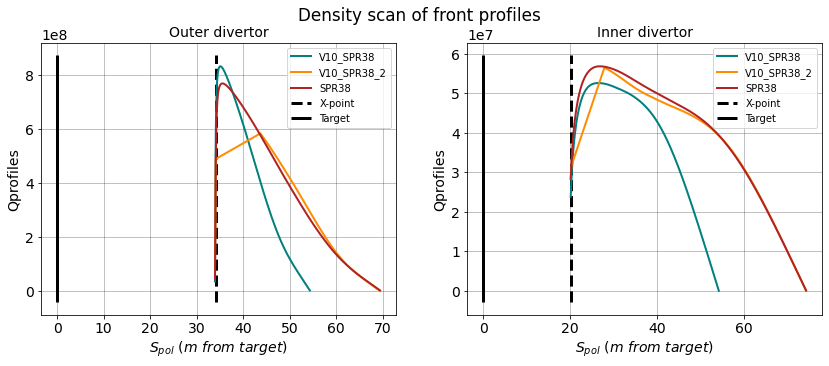

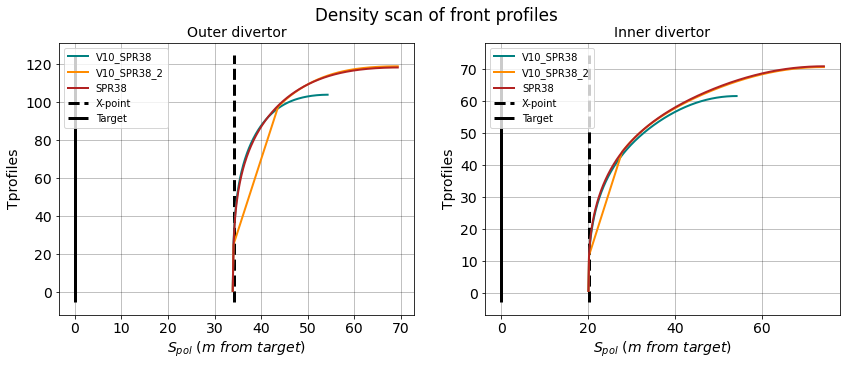

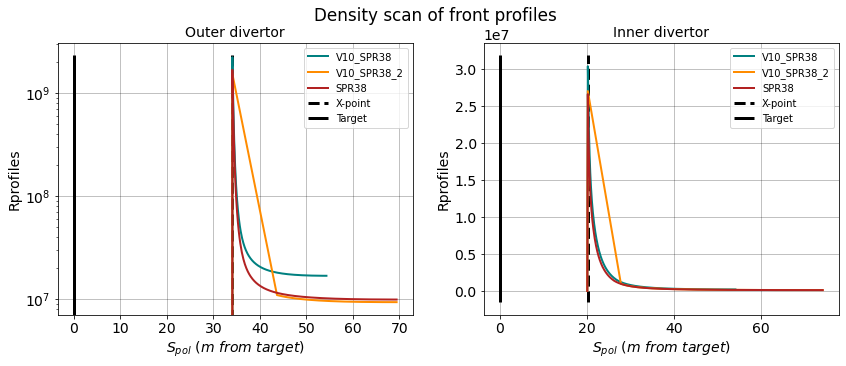

In [189]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
colors = mike_cmap(4)
list_designs = ["V10_SPR38", "V10_SPR38_2", "SPR38"]
store = syn_spr


for param in ["Qprofiles", "Tprofiles", "Rprofiles"]:

    fig, axes = plt.subplots(1,2, figsize = (14,5))
    fig.suptitle("Density scan of front profiles")
    ax = axes[0]

    for k, side in enumerate(["ou", "iu"]):

        for i, design in enumerate(list_designs):
            d = eqb[design][side]
            o = store[design][cvar][side]
            point = -1
            axes[k].plot(o["Sprofiles"][point], o[param][point], linewidth = 2,  color = colors[i], label = design)

        ylim = axes[k].get_ylim()
        axes[k].vlines(d["S"][d["Xpoint"]], ylim[0], ylim[1], label = "X-point", color = "black", linestyle = "dashed")
        axes[k].vlines(0, ylim[0], ylim[1], label = "Target", color = "black", linestyle = "solid")

    if param == "Rprofiles":
        ax.set_yscale("log")
    for ax in axes:
        ax.grid(color ="black", alpha = 0.3)
        ax.set_xlabel("$S_{pol}\ (m\ from\ target)$")
        ax.set_ylabel(param)
        ax.legend(fontsize = 10, loc = "best")
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
        # ax.set_xlim(30,35)
        # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    axes[0].set_title("Outer divertor")
    axes[1].set_title("Inner divertor")

In [64]:


np.trapz(d["Btot"][d["Xpoint"]:]/d["Btot"][d["Xpoint"]], x = d["S"][d["Xpoint"]:])

72.82714836556802

# Fix qradial

In [102]:
d = eqb["V10_SPR38"]["ou"]

Btot = d["Btot"]
Xpoint = d["Xpoint"]
S = d["S"]

qpllu0 = 1e9

Bratios = Btot[Xpoint:] / Btot[Xpoint]

# qradial = qpllu0 / (np.abs(S[-1] - S[Xpoint])) / trapz(Bratios, x = S[Xpoint:])
qradial = qpllu0/ np.trapz(Btot[Xpoint:] / Btot[Xpoint], x = S[Xpoint:])

q = trapz(qradial * Bratios, x = S[Xpoint:])

# for i, _ in enumerate(S[Xpoint:]):
    # q += qradial #* Btot[i] / Btot[Xpoint]
print("qradial: {:.3E}".format(qradial))
print("Final q: {:.3E}".format(q))

qradial: 6.055E+07
Final q: 1.000E+09


In [74]:
Bratios

array([1.        , 1.00001152, 1.00002478, ..., 1.75679096, 1.75679083,
       1.75679068])